# LDA

1. Using spacy to tokenize the docs
2. Considering bigrams
3. Creating word dictionary from tokens

In [62]:
import os
import PyPDF2
import pandas as pd
import numpy as np
import spacy
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [59]:
# Load english model: https://spacy.io/models
nlp = spacy.load('en')
nlp

In [256]:
with open('docs.pkl', 'rb') as f:
    data_df = pickle.load(f)
data_df.head()

,docs,pages
11000_pg_report_part_1.pdf,"11,000 PAGE REPORT\n0001-0100Library Injured (...",14
11000_pg_report_part_2.pdf,"11,000 PAGE REPORT\npgs.5501-5600 to 10901-109...",17
2014-NaBITA-Whitepaper-Text-with-Graphics.pdf,THREAT \nASSESSMENT IN THE \nCAMPUS \nSETTIN...,28
ACSO_000305-383_Arapahoe_Initial_Response.pdf,Arapahoe Initial Response ACSO AHS Investigati...,79
ACSO_000384-584_Assisting_Agencies-Part_1.pdf,CBI ACSO AHS Investigation ACSO 0000384 Color...,201


In [87]:
data_df['word_count']=data_df.docs.apply(len)
data_df['words_per_page']=data_df['word_count']/data_df['pages']

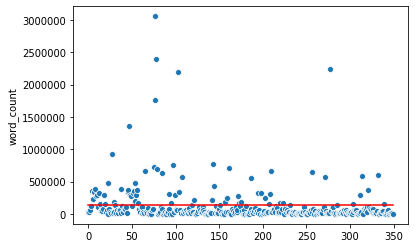

In [94]:
ax=sns.scatterplot(x=range(len(data_df)),y='word_count',data=data_df)
ax=sns.lineplot(x=range(len(data_df)),y=np.average(data_df['word_count']),color = 'r')

In [253]:
np.average(data_df['word_count'])

133873.05714285714

In [254]:
np.median(data_df['word_count'])

35333.0

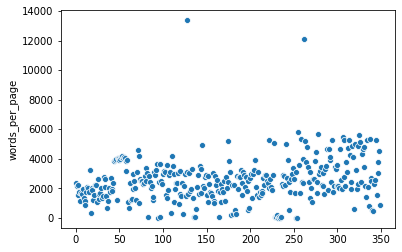

In [88]:
ax=sns.scatterplot(x=range(len(data_df)),y='words_per_page',data=data_df)

In [99]:
data_df[data_df['word_count']<100]

,docs,pages,word_count,words_per_page
Hribal_Letter.pdf,,4,11,2.75


In [89]:
data_df[data_df['words_per_page']>10000]

,docs,pages,word_count,words_per_page
Lanza_spreadsheet.pdf,1234567891011121314151617181920212223242526272...,4,53513,13378.2
harper-mercer_dating_profile.pdf,IRONCROSS45\nadd to friends list\nadd to frien...,1,12118,12118


### Note:
Still include outlier in the following analysis.\
For time and memory efficiency, I only use first 10000 words to conduct the analysis.

In [171]:
def split_text(text,n=10000):
    '''take text as input and return its first n percentage of elements'''
    
    if len(text)>n:
        return text[:n]
    else:
        return text

In [172]:
clean_split = lambda x:split_text(x)

In [173]:
data_df['split_docs']=data_df.docs.apply(clean_split)

### Text clean

In [221]:
# some helper function
def combine_texts(list_of_text):
    '''Taking a list of texts and combining them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text
def chunck_list(lst,chunck_size = 5000):
    '''to split large doc into batches, defualt batch size 5000'''
    for i in range(0,len(lst),chunck_size):
        yield lst[i:i+chunck_size]
        
# Data clean by spacy
def clean_text_pipe(text,allowed_postags=['PROPN','NOUN', 'ADJ', 'VERB', 'ADV']):
    '''Remove stop words and punctuaion'''
    BATCH_SIZE = 5000
    if len(text) > BATCH_SIZE:
        split_text = chunck_list(text)
        docs = [nlp(t) for t in split_text]
        cleaned_docs = []
        for doc in docs:
            cleaned_doc = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha and token.pos_ in allowed_postags]
            cleaned_text=' '.join(cleaned_doc)
            cleaned_docs.append(cleaned_text)
        return combine_texts(cleaned_docs)
    else:
        doc = nlp(text)
        cleaned_doc = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha and token.pos_ in allowed_postags]
        cleaned_text=' '.join(cleaned_doc)
        return cleaned_text 
clean_2 = lambda x: clean_text_pipe(x,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [222]:
data_clean = pd.DataFrame(data_df.split_docs.apply(clean_2))

### Tokenization and create dictionary

In [223]:
def tokenize_text(text):
    '''transforming text in to token'''
    token_list = text.split()
    return token_list

In [224]:
# pure_text: a list that conataining all the docs, pure_token: a list of docs into list of tokens
pure_text = data_clean.split_docs.values.tolist()
pure_token = list(map(tokenize_text,pure_text))

In [242]:
from gensim import corpora
INPUT = pure_token
# Create Dictionary
id2word = corpora.Dictionary(INPUT)
# Create Corpus
texts = INPUT
# Filter out words that occur less than and greater than
id2word.filter_extremes(no_below=1,no_above=300)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [243]:
# how many vocabularies are in the dictionary
len(id2word)

14650

### LDA using Bag of words

In [227]:
# LDA model
def run_LDA_model(corpus, id2word,TOPICS):
    '''This function returns lda models '''
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=TOPICS, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return lda_model

In [248]:
# Compute Coherence Score and search for the best topic numbers
from gensim.models import CoherenceModel

TOPICS_LIST = range(3,10)
lda_models = []
coherence_scores = []
for TOPICS in TOPICS_LIST:
    lda_model = run_LDA_model(corpus,id2word,TOPICS)
    lda_models.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=INPUT, dictionary=id2word, coherence='c_v')
    score = coherence_model_lda.get_coherence()
    coherence_scores.append(score)

Text(0, 0.5, 'Scores')

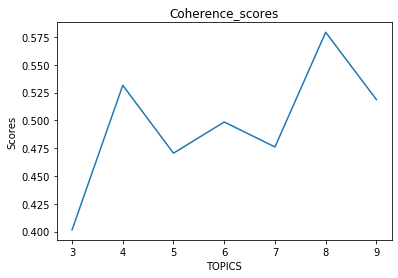

In [249]:
sns.lineplot(x= TOPICS_LIST,y=coherence_scores)
plt.title('Coherence_scores')
plt.xlabel('TOPICS')
plt.ylabel('Scores')

In [251]:
# see 4 topics 
best_lda_model = lda_models[1]
best_lda_model.print_topics()

[(0,
  '0.014*"school" + 0.010*"attack" + 0.008*"shooter" + 0.008*"know" + 0.007*"people" + 0.007*"kill" + 0.007*"say" + 0.007*"time" + 0.006*"go" + 0.005*"s"'),
 (1,
  '0.011*"address" + 0.011*"gender" + 0.008*"telephone" + 0.007*"classification" + 0.006*"send" + 0.005*"people" + 0.005*"female" + 0.004*"race" + 0.004*"mention" + 0.004*"weight"'),
 (2,
  '0.015*"school" + 0.010*"report" + 0.009*"student" + 0.009*"threat" + 0.008*"information" + 0.008*"violence" + 0.008*"law" + 0.007*"incident" + 0.007*"shooter" + 0.007*"shooting"'),
 (3,
  '0.019*"court" + 0.012*"trial" + 0.012*"defendant" + 0.010*"case" + 0.008*"state" + 0.008*"murder" + 0.007*"file" + 0.007*"appeal" + 0.006*"sentence" + 0.006*"count"')]

In [250]:
# see 8 topics
best_lda_model = lda_models[6]
best_lda_model.print_topics()

[(0,
  '0.014*"say" + 0.014*"know" + 0.013*"go" + 0.011*"tell" + 0.010*"time" + 0.009*"school" + 0.008*"gun" + 0.008*"friend" + 0.008*"want" + 0.008*"think"'),
 (1,
  '0.002*"yve" + 0.002*"pierre" + 0.001*"admissible" + 0.001*"gown" + 0.001*"darrell" + 0.001*"refresh" + 0.001*"inflection" + 0.001*"boisvert" + 0.001*"adjournment" + 0.001*"michel"'),
 (2,
  '0.021*"defendant" + 0.013*"murder" + 0.012*"court" + 0.010*"sentence" + 0.008*"jury" + 0.008*"trial" + 0.007*"count" + 0.007*"case" + 0.007*"criminal" + 0.007*"gun"'),
 (3,
  '0.026*"court" + 0.017*"trial" + 0.012*"state" + 0.011*"claim" + 0.010*"appeal" + 0.009*"motion" + 0.008*"counsel" + 0.008*"case" + 0.008*"issue" + 0.008*"order"'),
 (4,
  '0.023*"school" + 0.020*"attack" + 0.018*"shooter" + 0.009*"kill" + 0.007*"report" + 0.007*"violence" + 0.007*"people" + 0.006*"include" + 0.006*"family" + 0.006*"shooting"'),
 (5,
  '0.033*"case" + 0.032*"page" + 0.031*"document" + 0.023*"file" + 0.007*"date" + 0.007*"v" + 0.005*"number" + 0.

**Note:**\
the category probably goes into
1. case description
2. shooter or victims's info 
3. school's report
4. court's record

In [233]:
corpus_trans = best_lda_model[corpus]
# see which topics they are
for i in corpus_trans:
    print(i[0])        

[(0, 0.46434158), (3, 0.5332169)]
[(0, 0.9236541), (2, 0.075376)]
[(2, 0.9995132)]
[(0, 0.41451856), (2, 0.4225249), (3, 0.16291972)]
[(0, 0.01234357), (2, 0.5312555), (3, 0.4563339)]
[(0, 0.5178941), (2, 0.16179352), (3, 0.3202718)]
[(0, 0.8133083), (2, 0.121349074), (3, 0.065297164)]
[(0, 0.63800806), (2, 0.36183575)]
[(0, 0.92130184), (2, 0.07852876)]
[(0, 0.116199434), (2, 0.23435661), (3, 0.6493949)]
[(0, 0.2492757), (2, 0.7503342)]
[(0, 0.023368465), (1, 0.9572496), (2, 0.011778365)]
[(0, 0.13264543), (2, 0.8671853)]
[(0, 0.1912519), (2, 0.8085395)]
[(0, 0.094494484), (2, 0.2252018), (3, 0.6802657)]
[(0, 0.09969034), (2, 0.8061552), (3, 0.09411712)]
[(2, 0.10383914), (3, 0.89577454)]
[(0, 0.8692103), (2, 0.13060133)]
[(0, 0.38698557), (2, 0.6127872)]
[(0, 0.16137485), (2, 0.81878906), (3, 0.01979506)]
[(0, 0.20603473), (1, 0.013301385), (2, 0.03321219), (3, 0.7474517)]
[(0, 0.029605905), (2, 0.97016853)]
[(0, 0.2141875), (2, 0.7342322), (3, 0.051524885)]
[(0, 0.81593114), (2, 0.1

[(3, 0.99942607)]
[(0, 0.16551936), (3, 0.83424157)]
[(3, 0.9994361)]
[(0, 0.2982112), (3, 0.701554)]
[(2, 0.99833924)]
[(0, 0.14927964), (2, 0.8505306)]
[(0, 0.9996428)]
[(0, 0.9996561)]
[(0, 0.49687675), (1, 0.50250846)]
[(0, 0.06376964), (2, 0.028080944), (3, 0.90810907)]
[(3, 0.9963345)]
[(0, 0.91716933), (2, 0.077665426)]
[(0, 0.8034665), (2, 0.17032978), (3, 0.026136918)]
[(0, 0.5118677), (1, 0.052120183), (2, 0.2649375), (3, 0.17107463)]
[(0, 0.5482344), (2, 0.32847488), (3, 0.12321692)]
[(0, 0.81992865), (2, 0.17983474)]
[(0, 0.7687525), (2, 0.23099765)]
[(0, 0.73258334), (2, 0.2672504)]
[(0, 0.5118677), (1, 0.052120183), (2, 0.2649375), (3, 0.17107463)]
[(0, 0.5118677), (1, 0.052120183), (2, 0.2649375), (3, 0.17107463)]
[(0, 0.97490424), (1, 0.024769114)]
[(0, 0.999639)]
[(0, 0.99879605)]
[(0, 0.96129984), (1, 0.03835308)]
[(0, 0.99523693)]
[(0, 0.98452973), (3, 0.015241034)]
[(0, 0.8423329), (2, 0.15745136)]
[(0, 0.99967206)]
[(0, 0.99281573)]
[(0, 0.014301047), (2, 0.9855397

### LDA using tf-idf 

In [244]:
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Text(0, 0.5, 'Scores')

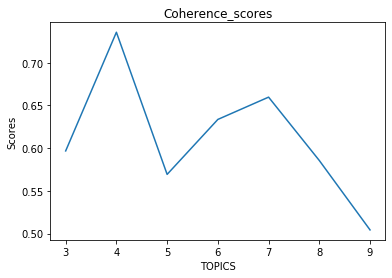

In [245]:
# Compute Coherence Score and search for the best topic numbers
from gensim.models import CoherenceModel

TOPICS_LIST = range(3,10)
lda_models = []
coherence_scores = []
for TOPICS in TOPICS_LIST:
    lda_model = run_LDA_model(corpus_tfidf,id2word,TOPICS)
    lda_models.append(lda_model)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=INPUT, dictionary=id2word, coherence='c_v')
    score = coherence_model_lda.get_coherence()
    coherence_scores.append(score)

sns.lineplot(x= TOPICS_LIST,y=coherence_scores)
plt.title('Coherence_scores')
plt.xlabel('TOPICS')
plt.ylabel('Scores')

In [246]:
best_lda_model = lda_models[1]
best_lda_model.print_topics()

[(0,
  '0.002*"attack" + 0.002*"shooter" + 0.001*"school" + 0.001*"perpetrator" + 0.001*"threat" + 0.001*"report" + 0.001*"court" + 0.001*"mother" + 0.001*"people" + 0.001*"violence"'),
 (1,
  '0.000*"breakfast" + 0.000*"erhu" + 0.000*"juvenilecomplaint" + 0.000*"partiesyellingwhileinthegarage" + 0.000*"hisvolunteerworkthatisrequiredofhimforschool" + 0.000*"johnstatedthat" + 0.000*"appearedtobehighandranoutthebackdoor" + 0.000*"johnstatedthathewouldcomplete" + 0.000*"hewasgoingtotakexxxtohisaameeting" + 0.000*"shefeltthatfilingchargeswasgoingtoruin"'),
 (2,
  '0.000*"relatedissue" + 0.000*"useofthisapproachhighlightsthe" + 0.000*"forlawenforcementagenciesthatreceiveanoverwhelmingnumberofcallsrelate" + 0.000*"traumatizedshooterscomefromseverelydysfunctionalhome" + 0.000*"tributetomassviolence" + 0.000*"twoconsiderationsguidedtheselectionprocessofperpetratorstopresentinthisarticle" + 0.000*"uniquetoperpetratorsintheunitedstate" + 0.000*"unusualperceptualexperiencesversushallucination" + 

# Next: